# Few-shot learning using a Siamese Network

## Initialization

In [1]:
# Install required libraries
!pip install -q torch_snippets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 499.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.2/204.2 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 64.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 51.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.8/30.8 MB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 32.8 MB/s eta 0:

In [2]:
# Import libraries
import os
import numpy as np

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms as T
from torchvision.utils import make_grid
from torch_snippets import *

import matplotlib.pyplot as plt

print(f"PyTorch Version: {torch.__version__}")
!nvidia-smi # check if GPU is available
%matplotlib inline

PyTorch Version: 2.2.1+cu121

Fri Apr 12 23:24:44 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", device)

Running on: cuda

In [4]:
# Download the dataset and extract it
!wget -q https://www.dropbox.com/s/ua1rr8btkmpqjxh/face-detection.zip
!unzip -q face-detection.zip

In [5]:
# Create Dataset class to fetch images and labels
class SiameseNetworkDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.folder = folder
        self.items = Glob(f'{self.folder}/*/*')
        self.transform = transform

    def __getitem__(self, idx):
        item_a = self.items[idx]
        person = fname(parent(item_a))
        same_person = randint(2)
        if same_person:
            item_b = choose(Glob(f'{self.folder}/{person}/*', silent=True))
        else:
            while True:
                item_b = choose(self.items)
                if person != fname(parent(item_b)):
                    break
        image_a = read(item_a)
        image_b = read(item_b)
        if self.transform:
            image_a = self.transform(image_a)
            image_b = self.transform(image_b)
        return image_a, image_b, np.array([1-same_person]) # 0 if same person, 1 if different

    def __len__(self):
        return len(self.items)


In [12]:
# Create training and validation transform pipelines
train_tfms = T.Compose([
    T.ToPILImage(),
    T.Grayscale(num_output_channels=1),
    T.RandomHorizontalFlip(),
    T.RandomAffine(5, (0.01, 0.2), scale=(0.9, 1.1)),
    T.Resize((100, 100)),
    T.ToTensor(),
    T.Normalize((0.5,), (0.5,))
])

val_tfms = T.Compose([
    T.ToPILImage(),
    T.Grayscale(num_output_channels=1),
    T.Resize((100, 100)),
    T.ToTensor(),
    T.Normalize((0.5,), (0.5,))
])

In [13]:
# Create train and validation datasets
train_ds = SiameseNetworkDataset(folder="./data/faces/training/", transform=train_tfms)
val_ds = SiameseNetworkDataset(folder="./data/faces/testing/", transform=val_tfms)

# Create a function to retrieve the dataloaders
def load_data(batch_size = 64):
    train_dl = DataLoader(train_ds, shuffle=True, batch_size=batch_size)
    val_dl = DataLoader(val_ds, shuffle=False, batch_size=batch_size)
    return train_dl, val_dl

In [14]:
# Create a function to define a convolutional block
def convBlock(n_inputs, n_outputs):
    return nn.Sequential(
        nn.Dropout(0.2),
        nn.Conv2d(n_inputs, n_outputs, kernel_size=3, padding=1, padding_mode='reflect'),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(n_outputs),
    )

# Create a class for the Siamese Network model
class SiameseNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            convBlock(1, 4),
            convBlock(4, 8),
            convBlock(8, 8),
            nn.Flatten(),
            nn.Linear(8*100*100, 500), nn.ReLU(inplace=True),
            nn.Linear(500, 500), nn.ReLU(inplace=True),
            nn.Linear(500, 5)
        )

    def forward(self, input1, input2):
        output1 = self.features(input1)
        output2 = self.features(input2)
        return output1, output2

In [15]:
# Create a class for the Contrastive Loss function
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """
    def __init__(self, margin=2.0):
        super().__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        acc = ((euclidean_distance > 0.6) == label).float().mean()
        return loss_contrastive, acc # Contrastive loss (Penalizes high euclidean distances for images of the same person)

In [16]:
# Create a function to train the model on a batch of data
def train_batch(model, data, criterion, optimizer):
    model.train()
    optimizer.zero_grad()
    images_a, images_b, labels = [tensor.to(device) for tensor in data]
    codes_a, codes_b = model(images_a, images_b)
    loss, acc = criterion(codes_a, codes_b, labels)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

# Create a function to validate the model on a batch of data
@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    images_a, images_b, labels = [tensor.to(device) for tensor in data]
    codes_a, codes_b = model(images_a, images_b)
    loss, acc = criterion(codes_a, codes_b, labels)
    return loss.item(), acc.item()

In [17]:
# Train the model
model = SiameseNetwork().to(device)
criterion = ContrastiveLoss()
optimizer = optim.Adam(model.parameters(),lr = 1e-3)
train_dl, val_dl = load_data()
n_epochs = 200

log = Report(n_epochs)
for epoch in range(n_epochs):
    n = len(train_dl)
    for i, data in enumerate(train_dl):
        loss, acc = train_batch(model, data, criterion, optimizer)
        log.record(epoch+(i+1)/n, train_loss=loss, train_acc=acc, end='\r')

    n = len(val_dl)
    for i, data in enumerate(val_dl):
        loss, acc = validate_batch(model, data, criterion)
        log.record(epoch+(i+1)/n, val_loss=loss, val_acc=acc, end='\r')

    if (epoch+1) % 20 == 0:
        log.report_avgs(epoch+1)

    if epoch == 10:
        optimizer = optim.Adam(model.parameters(), lr=5e-4)

EPOCH: 20.000  val_loss: 0.446  train_loss: 0.575  val_acc: 0.667  train_acc: 0.679  (29.68s - 267.14s remaining)
EPOCH: 40.000  val_loss: 0.594  train_loss: 0.473  val_acc: 0.867  train_acc: 0.722  (56.93s - 227.74s remaining)
EPOCH: 60.000  val_loss: 0.529  train_loss: 0.356  val_acc: 0.833  train_acc: 0.814  (84.19s - 196.45s remaining)
EPOCH: 80.000  val_loss: 0.373  train_loss: 0.274  val_acc: 0.900  train_acc: 0.829  (111.89s - 167.83s remaining)
EPOCH: 100.000  val_loss: 0.410  train_loss: 0.247  val_acc: 0.867  train_acc: 0.818  (139.23s - 139.23s remaining)
EPOCH: 120.000  val_loss: 0.257  train_loss: 0.221  val_acc: 0.800  train_acc: 0.894  (166.68s - 111.12s remaining)
EPOCH: 140.000  val_loss: 0.433  train_loss: 0.251  val_acc: 0.833  train_acc: 0.855  (194.07s - 83.17s remaining)
EPOCH: 160.000  val_loss: 0.296  train_loss: 0.200  val_acc: 0.733  train_acc: 0.856  (222.01s - 55.50s remaining)
EPOCH: 180.000  val_loss: 0.358  train_loss: 0.177  val_acc: 0.833  train_acc: 0.

100%|██████████| 301/301 [00:00<00:00, 5571.85it/s]


[04/12/24 23:41:51] INFO     metric val_loss was not fully recorded. Plotting final epochs using last recorded value                         ]8;id=888006;file:///usr/local/lib/python3.10/dist-packages/torch_snippets/torch_loader.py:733\torch_loader.py]8;;\:]8;id=544085;file:///usr/local/lib/python3.10/dist-packages/torch_snippets/torch_loader.py:733#plot_epochs:733\plot_epochs:733]8;;\

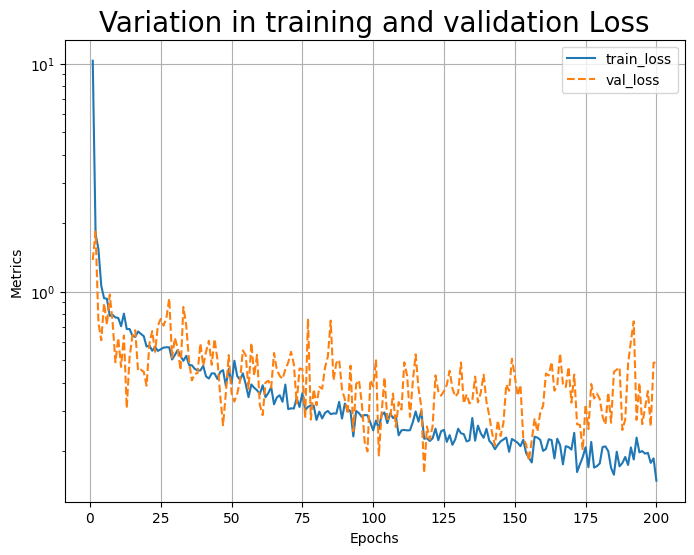

                    INFO     metric val_acc was not fully recorded. Plotting final epochs using last recorded value                          ]8;id=398157;file:///usr/local/lib/python3.10/dist-packages/torch_snippets/torch_loader.py:733\torch_loader.py]8;;\:]8;id=182427;file:///usr/local/lib/python3.10/dist-packages/torch_snippets/torch_loader.py:733#plot_epochs:733\plot_epochs:733]8;;\

100%|██████████| 301/301 [00:00<00:00, 6048.24it/s]


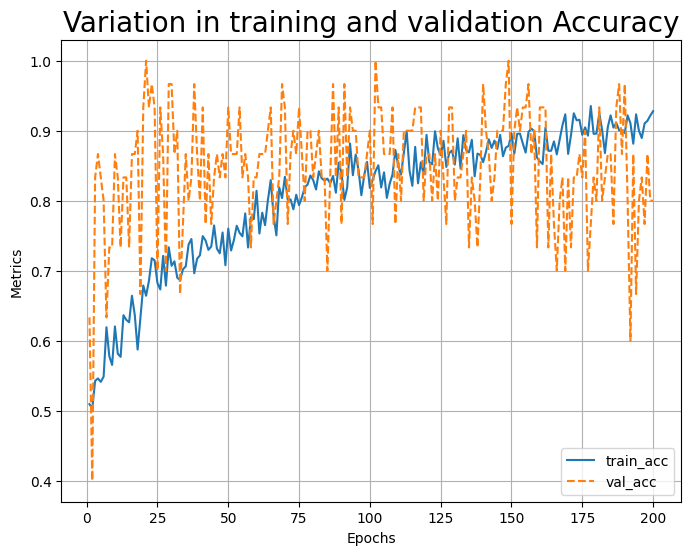

In [18]:
# Plot the training and validation loss and accuracy
log.plot_epochs(['train_loss', 'val_loss'], log=True, title='Variation in training and validation Loss')
log.plot_epochs(['train_acc', 'val_acc'], title='Variation in training and validation Accuracy')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


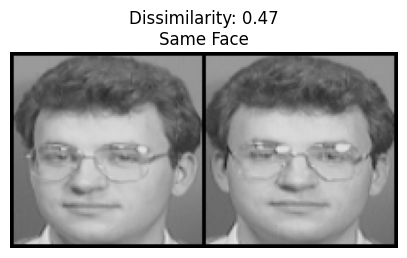

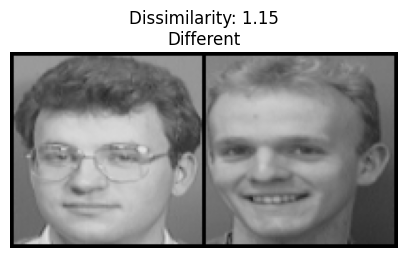

In [19]:
# Test the model with images from the validation dataset
model.eval()
val_dl = DataLoader(val_ds, num_workers=6, batch_size=1, shuffle=True)
dataiter = iter(val_dl)
images_a, _, _ = next(dataiter)

for _ in range(2):
     _, images_b, _ = next(dataiter)
     concatenated = torch.cat((images_a*0.5+0.5, images_b*0.5+0.5), 0)
     output1, output2 = model(images_a.cuda(), images_b.cuda())
     euclidean_distance = F.pairwise_distance(output1, output2)
     output = 'Same Face' if euclidean_distance.item() < 0.6 else 'Different'
     show(make_grid(concatenated), title='Dissimilarity: {:.2f}\n{}'.format(euclidean_distance.item(), output))
     plt.show()